# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- Emma Nilsson,
    2- Anna Fredriksson Häägg,
    3- Herman Kristian Dieset

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

# Imports

In [1]:
import tarfile
import os
import scipy.io
import skimage.io
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import svm
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import rgb2gray
import skimage.morphology as mp
from skimage import measure
import tensorflow as tf

#import sys
from IPython.display import clear_output

In [2]:
#data_base_path = os.path.join(os.pardir, 'data') # works for Herman
data_base_path = ('data')
data_folder = 'project-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
#with tarfile.open(tar_path, mode='r:gz') as tar:
#    tar.extractall(path=data_base_path)

In [3]:
def load_images():

    train_dir = os.path.join(data_base_path, data_folder +'/images/train/')
    dir_train_list = sorted(os.listdir(train_dir))
    train = [skimage.io.imread(os.path.join(train_dir, file)) for file in dir_train_list]

    
    test_dir = os.path.join(data_base_path, data_folder +'/images/test/')
    dir_test_list = sorted(os.listdir(test_dir))
    test = [skimage.io.imread(os.path.join(test_dir, file)) for file in dir_test_list]
    
    val_dir = os.path.join(data_base_path, data_folder +'/images/validation/')
    dir_val_list = sorted(os.listdir(val_dir))
    validation = [skimage.io.imread(os.path.join(val_dir, file)) for file in dir_val_list]
    
    return train, test, validation

In [4]:
def parse_xml_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [5]:
train, test, validation = load_images()

In [6]:
def load_annotations():
    dir_train = os.path.join(data_base_path, data_folder + '/annotations/train/')
    dir_train_list = sorted(os.listdir(dir_train))
    train_files = [f for f in dir_train_list if os.path.isfile(os.path.join(dir_train, f))]
    train_annotations = [parse_xml_file(os.path.join(dir_train, file)) for file in train_files]
    
    
    dir_test = os.path.join(data_base_path, data_folder + '/annotations/test/')
    dir_test_list = sorted(os.listdir(dir_test))
    test_files = [f for f in dir_test_list if os.path.isfile(os.path.join(dir_test, f))]
    test_annotations = [parse_xml_file(os.path.join(dir_test, file)) for file in test_files]
    
    dir_val = os.path.join(data_base_path, data_folder + '/annotations/validation/')
    dir_val_list = sorted(os.listdir(dir_val))
    val_files = [f for f in dir_val_list if os.path.isfile(os.path.join(dir_val, f))]
    validation_annotations = [parse_xml_file(os.path.join(dir_val, file)) for file in val_files]
    
    return train_annotations, test_annotations, validation_annotations

In [7]:
train_annotations, test_annotations, validation_annotations = load_annotations()

# Preprocessing 


In [8]:
def remove_yellow(img):
    out = img.copy()
    
    red = out[:,:,0]
    green = out[:,:,1]
    blue = out[:,:,2]
    
    is_yellow =  (red > 100) & (red < 250) & (green > 100) & (green < 250) & (blue > 0) & (blue < 200)
    
    red[is_yellow] = 255
    green[is_yellow] = 255
    blue[is_yellow] = 255
    
    out[:,:,0] = red
    out[:,:,1] = green
    out[:,:,2] = blue
    
    return out

In [9]:
#Thresholding the image between two thresholds
def threshold(image, th1, th2):
    th_img = image.copy()
    th_img[th_img<th1] = 0
    th_img[th_img>th2] = 0
    th_img[(th_img>=th1) & (th_img<=th2)] = 255
    return th_img

In [10]:
def erode(img, nb):
    out = img.copy()
    for i in range(nb):
        out = mp.erosion(mp.erosion(skimage.img_as_ubyte(img)))
    return out

In [11]:
def preprocess_image(img):
    out = img.copy()
    out = remove_yellow(out)
    img_g = rgb2gray(out)
    img_th = threshold(skimage.img_as_ubyte(img_g), 1, 100)
    img_er = erode(img_th,1)
    return img_er

"""
def preprocess_image(img):
    img = remove_yellow(img)
    img_g = rgb2gray(img)
    img_th = mp.erosion(mp.erosion(threshold(skimage.img_as_ubyte(img_g), 1, 100)))
    return img_th
    """  

'\ndef preprocess_image(img):\n    img = remove_yellow(img)\n    img_g = rgb2gray(img)\n    img_th = mp.erosion(mp.erosion(threshold(skimage.img_as_ubyte(img_g), 1, 100)))\n    return img_th\n    '

In [12]:
def preprocess_images(train, test, validation):
    train_out = train.copy()
    test_out = test.copy()
    val_out = validation.copy()
    
    for i in range(len(train_out)):
        train_out[i] = preprocess_image(train_out[i])
        
    for i in range(len(test_out)):
        test_out[i] = preprocess_image(test_out[i])
        
    for i in range(len(val_out)):
        val_out[i] = preprocess_image(val_out[i])
         
    return train_out, test_out, val_out


In [13]:
train_pro, test_pro, validation_pro = preprocess_images(train, test, validation[0:2])

/anaconda3/envs/ada/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [14]:
print("Nb train images     : {}".format(len(train_pro)))
print("Nb test images      : {}".format(len(test_pro)))
print("Nb validation images: {}".format(len(validation_pro)))

Nb train images     : 800
Nb test images      : 50
Nb validation images: 2


## Help functions for validation

In [15]:
def precision(tp, fp):
    return tp / (tp + fp)

def recall(tp, fn):
    return tp / (tp + fn)

def f1_score(tp, fp, fn):
    if (tp == 0):
        return 0
    return 2 * precision(tp, fp) * recall(tp, fn) / (precision(tp, fp) + recall(tp, fn))

def iou_bbox(predict, true):
    """
    Calculate the IoU for two bounding boxes.
    Based on:
    https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    """
    if type(predict[0]) == list or type(true[0]) == list :
        print((predict))
        print(true)
        #return 0
    # Determine the coordinates of the intersection rectangle
    x_left   = max(predict[0], true[0])
    y_bottom = max(predict[1], true[1])
    x_right  = min(predict[0] + predict[2], true[0] + true[2])
    y_top    = min(predict[1] + predict[3], true[1] + true[3])

    # If they do not overlap, return 0
    if x_right < x_left or y_bottom > y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_top - y_bottom)

    # Compute area for both bounding boxes
    bb1_area = predict[2] * predict[3]
    bb2_area = true[2] * true[3]

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    return iou

## Validation function

In [16]:
def validate_method(method, test_between = None, printVals = False, test_imgs = test_pro):
    
    def update_progress(progress):
        bar_length = 30
        if isinstance(progress, int):
            progress = float(progress)
        if not isinstance(progress, float):
            progress = 0
        if progress < 0:
            progress = 0
        if progress >= 1:
            progress = 1
            
        block = int(round(bar_length * progress))
        clear_output(wait = True)
        text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
        print(text)

    tp = 0
    fp = 0
    fn = 0
    
    # setup progress bar
    limit = len(test_imgs[test_between[0]:test_between[1]] if nb_test_images != None else test_imgs)

    for i in range(limit):
        update_progress(i/limit)
        # predict varroas
        varroas_pred = method(test_imgs[i])

        # get true bounding boxes
        varroas_true = []
        for bbox in test_annotations[i]:
               varroas_true.append(bbox['bbox'])

        # get true and false positives
        positives = []

        for pb in varroas_pred:
            true_pos = False

            for tb in varroas_true:
                if(iou_bbox(pb, tb) > 0.3):
                    true_pos = True
                    break;
            positives.append(true_pos)

        tp += positives.count(True)
        fp += positives.count(False)

        # get the false negatives
        negatives = []

        for tb in varroas_true:
            fn = False

            for pb in varroas_pred:
                if(iou_bbox(pb, tb) > 0.3):
                    fn = True
                    break;
            negatives.append(fn)

        # Count all times no intersection was found
        fn += negatives.count(False)
    update_progress(1)
    
    if printVals :
        print('The values for the given test images')
        print(tp)
        print(fn)
        print(fp)

    
    print("\n----------- SCORES -----------")
    print("Precision: {}".format(precision(tp,fp)))
    print("Recall   : {}".format(recall(tp,fn)))
    print("F1-score : {}".format(f1_score(tp,fp,fn)))
    print("------------------------------")

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [19]:
def find_contours(img):
    contours = measure.find_contours(img, 0)
    lengths = []
    for cnt in contours:
        lengths.append(len(cnt))
    return contours, lengths

In [20]:
def contour_threshold_length(contours, th_low = 0, th_high = np.Inf) :
    # filters list of contours, keeps those within threshold limits
    out = []
    for n, contour in enumerate(contours):
        if len(contour) > th_low and len(contour) < th_high :
            out.append(contour)
    return out, len(out)

In [21]:
def contours2boxlist(contours):
    boxes = []
    for contour in contours :
        x_min = int(np.min(contour[:,1]))
        x_max = int(np.max(contour[:,1]))
        y_min = int(np.min(contour[:,0]))
        y_max = int(np.max(contour[:,0]))
        
        boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])
    
    return boxes # [[x_1, y_1, w_1, h_2]

In [22]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    #img = preprocess_image(img)
    contours,_ = find_contours(img)
    contours,_ = contour_threshold_length(contours,40,80)
    boxlist = contours2boxlist(contours)
    
    return boxlist

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [39]:
#Your code
validate_method(detect_by_segmentation)

Progress: [##############################] 100.0%

----------- SCORES -----------
Precision: 0.04203670811130847
Recall   : 0.9861111111111112
F1-score : 0.08063600227143669
------------------------------


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [17]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

We need to create our training features for the classifier. This is done by first finding the contours for all training annotations and then using them to compute the first 10 fourier descriptors of all contours. These will be our features.

In [21]:
def get_contours(images, annotations):
    '''
    Input: Training images and training annotations
    Output: Max length of the contours and an array with the contours of all training varroas
    '''
    max_len = 0
    all_contours = []
    
    for i in range(len(images)):
        for anno in annotations[i]:
            bbox = anno['bbox']
            img_box = images[i][bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]].copy()
            im_bw = img_box

            # Find contours using opencv
            _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            # Reshape to easily get x and y
            if (len(contours) != 0):
                contours_np = contours[0][:, 0, :]
                all_contours.append(contours_np)

                if (max_len < contours_np.shape[0]):
                    max_len = contours_np.shape[0]

    return max_len, np.array(all_contours)

In [25]:
def fourier_descriptor(contours, length):
    '''
    Input: one contour, max lenght of all contours
    Output: The 10 first fourrier descriptors of the contour
    '''
    
    # Pad contour to max contour length
    for i in range(length - len(contours)):
        contours = np.concatenate([contours, np.array([[0, 0]])])
    
    # Create imag nums and descriptors
    u_k = contours[:, 0] + 1j*contours[:, 1]
    
    fr = np.fft.fft(u_k)
    
    # Only return the 2nd and 3rd
    return [fr[1], fr[2], fr[3], fr[4], fr[5], fr[6]]

Create and normalize training features 

In [26]:
max_len, contours = get_contours(train_pro, train_annotations)
features = np.abs([(fourier_descriptor(c, max_len)) for c in contours])

In [27]:
features = np.c_[ features, np.zeros(features.shape[0]) ]  
scaler = preprocessing.StandardScaler().fit(features[:, 0:6])
features_s = scaler.transform(features[:, 0:6])

Train a classifier


In [30]:
clf_svm_one = svm.OneClassSVM(nu=0.9)
clf_svm_one.fit(features_s)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.95, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

# Test the detection

To not miss any varroas the sliding window will take quite small steps (6-8px). This means that one varroa might be found several times. A merge_box function is implemented to merge overlapping bounding boxes before returning them.

In [229]:
def merge_boxes(bboxes_in):
    bboxes = bboxes_in.copy()
    for i in range(len(bboxes)):
        for j in range(i+1, len(bboxes)):
            if(iou_bbox(bboxes[i], bboxes[j]) > 0.3):
                print('eee')

                # Determine the coordinates of the intersection rectangle
                x_left = min(bboxes[i][0], bboxes[j][0])
                y_top = min(bboxes[i][1], bboxes[j][1])
                x_right = max(bboxes[i][0] + bboxes[i][2], bboxes[j][0] + bboxes[j][2])
                y_bottom = max(bboxes[i][1] + bboxes[i][3], bboxes[j][1] + bboxes[j][3])
                
                bboxes[j] = [x_left, y_top, x_right - x_left, y_bottom - y_top]
                del bboxes[i]
                break
    return bboxes

In [34]:
def detect_by_method_1(image):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    window_shape = (45, 45)
    padding = max_len
    varroas = []
    for window in sliding_window(image, 6, window_shape):
        im_bw = window[2]

        # Find contours using opencv
        _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        #print(len(contours))

        # Reshape to easily get x and y
        if (len(contours) > 0):
            contours_np = contours[0][:, 0, :]
            descriptor = np.abs(fourier_descriptor(contours_np, padding))
            test_ = scaler.transform(np.array([descriptor[:]]))
            prob = clf_svm_one.predict(test_.reshape(1, -1))
            # print(prob)
            if (prob > 0):
                varroas.append([window[0], window[1], window_shape[0], window_shape[1]])

    return merge_boxes(varroas)

Validation of result by repporting the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [38]:
validate_method(detect_by_method_1)

Progress: [##############################] 100.0%

----------- SCORES -----------
Precision: 0.09669211195928754
Recall   : 0.9047619047619048
F1-score : 0.17471264367816094
------------------------------


From our high recall but really low precision score, we can conclude that we catch most varroas, but also a lot of objects which are not varroas. Improved preprocessing for the images might have helped us elevate the precision, but we think deep learning will be the best solution to the problem.

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

Create training data

In [102]:
def get_varroa_images(images, annotations, width, height, channels=3):
    '''
    Input: Training images and training annotations
    Output: An array with all varroa images
    '''
    varroas = []
    for i in range(len(images)):
        for anno in annotations[i]:
            bbox = anno['bbox']
            img_box = images[i][bbox[1]:bbox[1]+height, bbox[0]:bbox[0]+width].copy()

            if (channels != 3):
                img_box = np.expand_dims(img_box, axis=2)

            if (img_box.shape == (height, width, channels)):
                varroas.append(img_box)

    return varroas

In [251]:
def create_second_class_images(images, annotations, width, height, channels=3):
    # Find all images without varroas
    empty_anno_index = []
    for i in range(len(annotations)):
        if len(annotations[i]) == 0:
            empty_anno_index.append(i)

    # Store the first 5 images (change later)
    #print(len(empty_anno_index))
    #empty_anno_index = empty_anno_index[:100]
    empty_pics = [images[i] for i in empty_anno_index]
    
    no_varroas = []
    
    # Slide over images and append all windows to the second class data array
    for image in empty_pics:
        for window in sliding_window(image, 300, (height, width)):
            no_varroa_img = window[2]
            if (channels != 3):
                no_varroa_img = np.expand_dims(no_varroa_img, axis=2)
            if (no_varroa_img.shape == (height, width, channels)):
                no_varroas.append(no_varroa_img)

    return no_varroas

Create train features and save them.

In [252]:
window_shape = (45, 45)
varroas_pos = np.stack(get_varroa_images(train, train_annotations, window_shape[0], window_shape[1]), axis=0)
varroas_neg = np.stack(create_second_class_images(train, train_annotations, window_shape[0], window_shape[1]), axis=0)
train_features = np.vstack((varroas_pos, varroas_neg))

In [253]:
train_features.shape

(17450, 45, 45, 3)

Create train labels.

In [254]:
label_pos = np.ones((varroas_pos.shape[0]))
label_neg = np.zeros((varroas_neg.shape[0]))
train_labels = np.concatenate((label_pos, label_neg))

In [255]:
train_labels.shape

(17450,)

In [256]:
train_features_float = train_features.astype(np.float32)

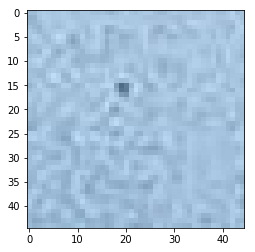

In [257]:
plt.imshow(train_features[-10000])

### Keras imports, helpers etc

In [240]:
from tensorflow import keras 
from keras.layers import Conv2D, MaxPooling2D
#from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, concatenate, Activation, Dropout, Flatten
from keras.models import Model
from keras import optimizers

In [241]:
def split_data(x, y, ratio=0.8, seed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

In [74]:
# Reshaping data for MLP
train_linear = train_features_float.reshape((-1, 45*45*3)).astype(np.float32)

In [75]:
x_train, x_test, y_train, y_test = split_data(train_linear/255, train_labels)
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [76]:
x_train.shape

(71215, 6075)

### MLP

In [174]:
model_mlp = Sequential()

model_mlp.add(Dense(8192, activation='relu', input_dim=x_train.shape[1]))
model_mlp.add(Dense(4096, activation='relu'))
model_mlp.add(Dense(2048, activation='relu'))
model_mlp.add(Dense(1024, activation='relu'))
model_mlp.add(Dense(512, activation='relu'))

model_mlp.add(Dense(2, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_mlp.compile(
    loss='binary_crossentropy',
    optimizer=sgd,
    metrics=['accuracy']
)

In [175]:
model_mlp.fit(
        x_train,
        y_train,
        batch_size=100,
        epochs=5,
        validation_data=(x_test, y_test)
    )

Train on 10042 samples, validate on 2511 samples
Epoch 1/5
10042/10042 [==============================] - 91s 9ms/step - loss: 0.6817 - acc: 0.5850 - val_loss: 0.6774 - val_acc: 0.5806
Epoch 2/5
10042/10042 [==============================] - 103s 10ms/step - loss: 0.6748 - acc: 0.5856 - val_loss: 0.6754 - val_acc: 0.5806
Epoch 3/5
10042/10042 [==============================] - 94s 9ms/step - loss: 0.6734 - acc: 0.5856 - val_loss: 0.6745 - val_acc: 0.5806
Epoch 4/5
10042/10042 [==============================] - 89s 9ms/step - loss: 0.6725 - acc: 0.5856 - val_loss: 0.6737 - val_acc: 0.5806
Epoch 5/5
10042/10042 [==============================] - 94s 9ms/step - loss: 0.6717 - acc: 0.5856 - val_loss: 0.6729 - val_acc: 0.5806


### CNN

Defined a CNN with 3 convolutional layers.

In [267]:
# Create input layer
input_ = Input(shape=(45, 45, 3), dtype='float32')

# Create convolution and max pooling layers
conv1 = Conv2D(filters=16, kernel_size=5, padding='valid', activation='relu', strides=1)(input_)
max1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(filters=32, kernel_size=5, padding='valid', activation='relu', strides=1)(max1)
max2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(filters=64, kernel_size=5, padding='valid', activation='relu', strides=1)(max2)
max3 = MaxPooling2D(pool_size=(2,2))(conv3)

# Flatten
flatten = Flatten()(max3)

# Dropout, activation
linear = Dense(256, activation='relu')(flatten)
output = Dense(2, activation='softmax')(linear)

# Create and compile model
adam = optimizers.Adam()
model_cnn = Model(inputs=[input_], outputs=[output])
model_cnn.compile(
    loss='binary_crossentropy',
    optimizer=sgd,
    metrics=['accuracy']
)

In [268]:
x_train, x_test, y_train, y_test = split_data(train_features_float/255, train_labels)
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [260]:
model_cnn.fit(
        x_train,
        y_train,
        batch_size=100,
        epochs=3,
        validation_data=(x_test, y_test)
    )

Train on 13960 samples, validate on 3490 samples
Epoch 1/3
13960/13960 [==============================] - 19s 1ms/step - loss: 0.4209 - acc: 0.8798 - val_loss: 0.1798 - val_acc: 0.9436
Epoch 2/3
13960/13960 [==============================] - 19s 1ms/step - loss: 0.1384 - acc: 0.9602 - val_loss: 0.1343 - val_acc: 0.9619
Epoch 3/3
13960/13960 [==============================] - 19s 1ms/step - loss: 0.1175 - acc: 0.9677 - val_loss: 0.1173 - val_acc: 0.9668


### Predictions

In [246]:
def merge_boxes(bboxes_in):
    bboxes = bboxes_in.copy()
    for i in range(len(bboxes)):
        for j in range(i+1, len(bboxes)):
            if(iou_bbox(bboxes[i], bboxes[j]) > 0.05):
                # Determine the coordinates of the intersection rectangle
                x_left = min(bboxes[i][0], bboxes[j][0])
                y_top = min(bboxes[i][1], bboxes[j][1])
                x_right = max(bboxes[i][0] + bboxes[i][2], bboxes[j][0] + bboxes[j][2])
                y_bottom = max(bboxes[i][1] + bboxes[i][3], bboxes[j][1] + bboxes[j][3])
                
                bboxes[j] = [x_left, y_top, x_right - x_left, y_bottom - y_top]
                del bboxes[i]
                break
    return bboxes

In [247]:
def merge_boxes_improved(bboxes_in):
    rects, weights = cv2.groupRectangles(bboxes_in, groupThreshold=1, eps=1)
    
    return rects

In [263]:
def detect_by_cnn(image):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    window_shape = (45, 45)
    varroas = []
    for window in sliding_window((image)/255, 15, window_shape):
        im_bw = window[2]

        if (im_bw.shape == (window_shape[0], window_shape[1], 3)):
            im_bw = np.reshape(im_bw, [1, 45, 45, 3])
            prob = model_cnn.predict(im_bw)
            #print(prob[0][1])
            index = np.argmax(prob)
            

            if (prob[0][1] > 0.97):
                varroas.append([window[0], window[1], window_shape[0], window_shape[1]])

    return merge_boxes_improved(varroas)

In [264]:
hm = detect_by_cnn((test[23]))

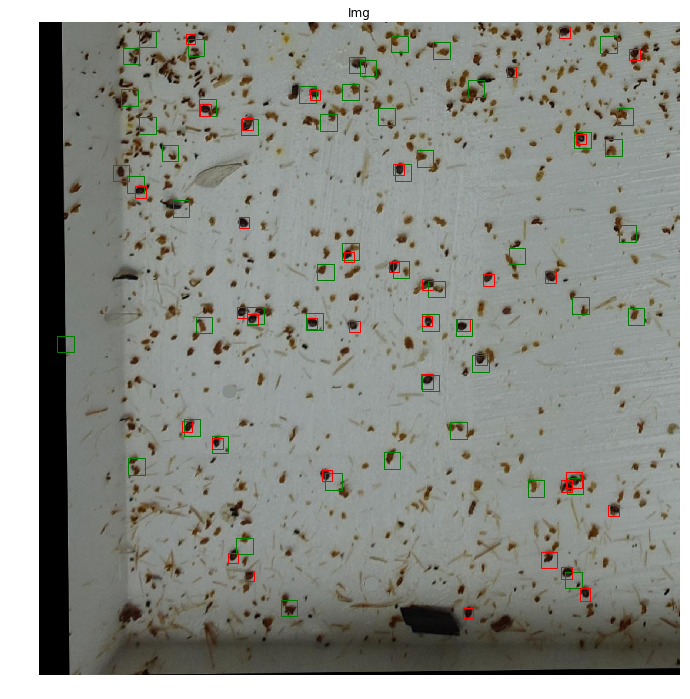

In [265]:
# Plot images
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

#varroas_pred_merged, varroas_pred = detect_by_cnn(test[11])
# Iterate over annotations

for anno in hm:
    rect = patches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
            linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect)


# Iterate over annotations
for anno in test_annotations[23]:
    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

ax.imshow((test[23]))
ax.axis('off')
ax.set_title('Img')
plt.show()

In [266]:
validate_method(detect_by_cnn, nb_test_images=25, test_imgs=test)

Progress: [##############################] 100.0%

----------- SCORES -----------
Precision: 0.2288329519450801
Recall   : 0.8
F1-score : 0.3558718861209965
------------------------------


## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code

## Appendix: plotting functions

In [14]:
def plot_image(img):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    size = img.shape
    if len(size) == 3:
        ax.imshow(img)
        ax.set_title('({} px, {} px, depth {})'.format(size[0], size[1], size[2]))
    else:
        ax.imshow(img, cmap='gray')
        ax.set_title('({} px, {} px), single channel'.format(size[0], size[1]))
    plt.show()

In [24]:
def plot_with_annotation(img_nb, annotations, img = None):
    if annotations == [] : 
        print("No varroa here!")
        return None
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], 
                                  anno['bbox'][1]), 
                                  anno['bbox'][2],
                                  anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    if img is not None: # img from argument
        size = img.shape
        if len(size) == 3:
            ax.imshow(img)
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px, depth {})'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1], size[2]))
        else:
            ax.imshow(img, cmap='gray')
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px), single channel'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1]))
    else: # image from collection
        size = img_collection[img_nb].shape
        if len(size) == 3:
            ax.imshow(img_collection[img_nb])
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px, depth {})'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1], size[2]))
        else:
            ax.imshow(img_collection[img_nb], cmap='gray')
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px), single channel'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1]))
    plt.show()

In [16]:
def plot_contours(img, th_low = 0, th_high = np.Inf):
    # Find contours
    contours,l = find_contours(img)
    plt.subplots(1,1,figsize=(6,6))

    plt.gca().invert_yaxis()
    
    contours,l = contour_threshold_length(contours, th_low, th_high)
    
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    plt.title("{} contours between threholds {} and {}".format(l,
                                                              th_low,
                                                              th_high))
    plt.show()

def plot_contours_histogram(img):
    _, lengths = find_contours(img)
    plt.subplots(1,1,figsize=(10,6))
    plt.hist(lengths, bins='auto')
    plt.title("Histogram with 'auto' bins")
    plt.show()

In [20]:
def plot_boxlist_and_annotations(img_nb, boxlist, annotations) :
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    
    # plot boxes
    tmp_im = np.zeros(img_collection[img_nb].shape)
    for box in boxlist:
        #print(box)
        for x in range(box[0], box[2] + box[0]) :
            for y in range(box[1], box[3] + box[1]):
                tmp_im[y,x] = 1.0
    ax.imshow(tmp_im, cmap = 'gray')
    
    # plot annotations
    if annotations != [] : 
        for anno in annotations:
            rect = patches.Rectangle((anno['bbox'][0], 
                                      anno['bbox'][1]), 
                                      anno['bbox'][2],
                                      anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        no_varroa = len(annotations)
    else:
        no_varroa = 0

    #ax.imshow(img_collection[img_nb], cmap='gray')
    ax.set_title('img nb {}, no varroae {}, no boxes {}'.format(
        img_nb,no_varroa, len(boxlist)))
    plt.show()

In [21]:
def plot_contours_and_annotations(img_nb, contours, annotations) :
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    
    # plot contours
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    # plot annotations
    if annotations != [] :
        for anno in annotations:
            rect = patches.Rectangle((anno['bbox'][0], 
                                      anno['bbox'][1]), 
                                      anno['bbox'][2],
                                      anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        no_varroa = len(annotations)
    else:
        no_varroa = 0

    #ax.imshow(img_collection[img_nb], cmap='gray')
    ax.set_title('img nb {}, no varroae {}, no contours {}'.format(
        img_nb,no_varroa, len(contours)))
    
    plt.gca().invert_yaxis()
    plt.show()